### Task 5 - Predictive Modelling

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load data
df = pd.read_csv("datasets/falcon9_dataset.csv")
df.head()

,FlightNumber,Date,Hour,Minute,BoosterVersion,PayloadMass,Orbit,LaunchSite,Serial,Block,Longitude,Latitude,Outcome,LandingPlace,Year,Month,Day,Flights,Reused
0,1,2010-06-04,18,45,Falcon 9,0.0,LEO,CCSFS SLC 40,B0003,1.0,-80.577366,28.561857,0,Ocean,2010,6,4,1,False
1,2,2010-12-08,15,43,Falcon 9,2115.0,ISS,CCSFS SLC 40,B0004,1.0,-80.577366,28.561857,0,Ocean,2010,12,8,1,False
2,6,2013-09-29,16,0,Falcon 9,500.0,PO,VSFB SLC 4E,B1003,1.0,-120.610829,34.632093,0,Ocean,2013,9,29,1,False
3,9,2014-04-18,19,25,Falcon 9,2296.0,ISS,CCSFS SLC 40,B1015,1.0,-80.577366,28.561857,1,Ocean,2014,4,18,1,False
4,10,2014-07-14,15,15,Falcon 9,1316.0,LEO,CCSFS SLC 40,B1018,1.0,-80.577366,28.561857,1,Ocean,2014,7,14,1,False


In [ ]:
df = df[['Year','Month','Day','Hour','Minute','PayloadMass','LaunchSite',
         'Orbit','Serial','Block','LandingPlace','Flights','Reused','Outcome']]
df.dtypes

Year              int64
Month             int64
Day               int64
Hour              int64
Minute            int64
PayloadMass     float64
LaunchSite       object
Orbit            object
Serial           object
Block           float64
LandingPlace     object
Flights           int64
Reused             bool
Outcome           int64
dtype: object

In [ ]:
n_fail = sum(df['Outcome'] == 0)
total = len(df)
print(f'All predict 1 accuracy = {(total-n_fail)/total}')

All predict 1 accuracy = 0.9396551724137931


### Categorical features to numerical data (one-hot encoding)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

# df['Year'] = df['Year'].astype(str)
year_encoded = encoder.fit_transform(df[['Year']])
year_encoded_df = pd.DataFrame(year_encoded.toarray(), columns=encoder.get_feature_names_out(['Year']))

hour_encoded = encoder.fit_transform(df[['Hour']])
hour_encoded_df = pd.DataFrame(hour_encoded.toarray(), columns=encoder.get_feature_names_out(['Hour']))

launchsite_encoded = encoder.fit_transform(df[['LaunchSite']])
launchsite_encoded_df = pd.DataFrame(launchsite_encoded.toarray(), columns=encoder.get_feature_names_out(['LaunchSite']))

orbit_encoded = encoder.fit_transform(df[['Orbit']])
orbit_encoded_df = pd.DataFrame(orbit_encoded.toarray(), columns=encoder.get_feature_names_out(['Orbit']))

# serial_encoded = encoder.fit_transform(df[['Serial']])
# serial_encoded_df = pd.DataFrame(serial_encoded.toarray(), columns=encoder.get_feature_names_out(['Serial']))

block_encoded = encoder.fit_transform(df[['Block']])
block_encoded_df = pd.DataFrame(block_encoded.toarray(), columns=encoder.get_feature_names_out(['Block']))

landingplace_encoded = encoder.fit_transform(df[['LandingPlace']])
landingplace_encoded_df = pd.DataFrame(landingplace_encoded.toarray(), columns=encoder.get_feature_names_out(['LandingPlace']))

encoded_df = pd.concat([df[['PayloadMass','Reused']], year_encoded_df,
                        orbit_encoded_df, block_encoded_df, launchsite_encoded_df,
                        landingplace_encoded_df, df['Outcome']], axis=1)


X = encoded_df.iloc[:, :-1]
y = encoded_df['Outcome']

encoded_df.head()

,PayloadMass,Reused,Year_2010,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,...,Block_3.0,Block_4.0,Block_5.0,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VSFB SLC 4E,LandingPlace_Drone ship,LandingPlace_Ground pad,LandingPlace_Ocean,Outcome
0,0.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
1,2115.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2,500.0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,2296.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,1316.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1


### Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler()
X['PayloadMass'] = transformer.fit_transform(X[['PayloadMass']])

### Split data into training and testing

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True, random_state=111)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(174, 35) (58, 35) (174,) (58,)


### Modelling

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

### Model1: KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_pred_cls = []
knn_pred_prob = []
knn_true_cls = []
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_fold, y_train_fold)

    knn_pred_prob.append(knn.predict_proba(X_val_fold))
    knn_pred_cls.append(knn.predict(X_val_fold))
    knn_true_cls.append(y_val_fold)

knn_pred_cls = np.concatenate(knn_pred_cls)
knn_pred_prob = np.concatenate(knn_pred_prob)
knn_true_cls = np.concatenate(knn_true_cls)

knn_acc = accuracy_score(knn_true_cls, knn_pred_cls)
knn_f1 = f1_score(knn_true_cls, knn_pred_cls)
knn_cm = confusion_matrix(knn_true_cls, knn_pred_cls)

print(f'Knn average accuracy = {knn_acc}, F1 score = {knn_f1}')

Knn average accuracy = 0.9597701149425287, F1 score = 0.9788519637462235


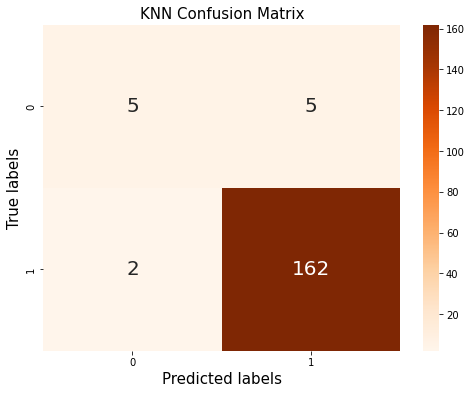

In [ ]:
# plot confusion matrix
classes = np.unique(knn_true_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, cmap='Oranges', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('KNN Confusion Matrix', fontsize=15)
plt.show()

KNN test accuracy = 0.9482758620689655, F1 score = 0.972972972972973


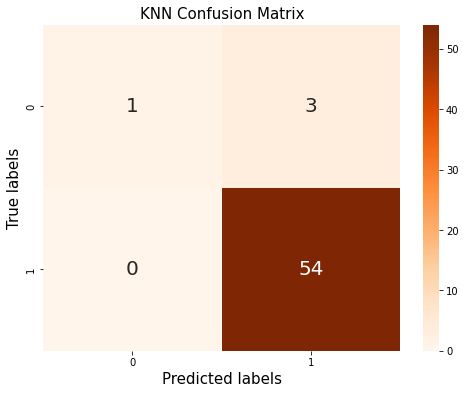

In [ ]:
# KNN test
knn_test_pred = knn.predict(X_test)
knn_test_prob = knn.predict_proba(X_test)

knn_test_acc = accuracy_score(y_test, knn_test_pred)
knn_test_f1 = f1_score(y_test, knn_test_pred)
knn_test_cm = confusion_matrix(y_test, knn_test_pred)
print(f'KNN test accuracy = {knn_test_acc}, F1 score = {knn_test_f1}')

classes = np.unique(y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_test_cm, annot=True, cmap='Oranges', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('KNN Confusion Matrix', fontsize=15)
plt.show()

### Model 2: Gradient Boosting

In [ ]:
from xgboost import XGBClassifier

xgb_pred_cls = []
xgb_pred_prob = []
xgb_true_cls = []
tn_indices = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the XGBClassifier
    xgb = XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=3, use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train_fold, y_train_fold)

    # Predict the validation fold
    y_pred_fold = xgb.predict(X_val_fold)
    y_prob_fold = xgb.predict_proba(X_val_fold)

    # Append the predictions and true labels
    xgb_pred_cls.append(y_pred_fold)
    xgb_pred_prob.append(y_prob_fold)
    xgb_true_cls.append(y_val_fold)

    # Identify TN instances for the fold
    tn_mask = (y_pred_fold == 0) & (y_val_fold == 0)
    tn_indices.append(val_index[tn_mask])

# Concatenate the results
xgb_pred_cls = np.concatenate(xgb_pred_cls)
xgb_pred_prob = np.concatenate(xgb_pred_prob)
xgb_true_cls = np.concatenate(xgb_true_cls)

# Evaluate the overall performance
xgb_acc = accuracy_score(xgb_true_cls, xgb_pred_cls)
xgb_f1 = f1_score(xgb_true_cls, xgb_pred_cls)
xgb_cm = confusion_matrix(xgb_true_cls, xgb_pred_cls)

print(f'Gradient Boosting average accuracy = {xgb_acc}, F1 score = {xgb_f1}')

# Concatenate all true negative indices from all folds
tn_indices = np.concatenate(tn_indices)
print(tn_indices)

Gradient Boosting average accuracy = 0.9597701149425287, F1 score = 0.9787234042553191
[ 57 101 150  66  21  84]


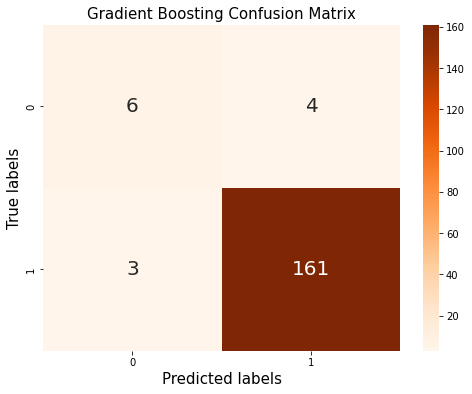

In [ ]:
# plot confusion matrix
classes = np.unique(xgb_true_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, cmap='Oranges', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Gradient Boosting Confusion Matrix', fontsize=15)
plt.show()

Gradient Boosting test accuracy = 0.9482758620689655, F1 score = 0.9724770642201835


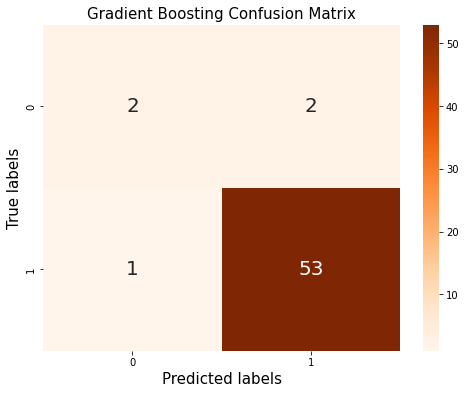

In [ ]:
# Gradient Boosting test
xgb_test_pred = xgb.predict(X_test)
xgb_test_prob = xgb.predict_proba(X_test)

xgb_test_acc = accuracy_score(y_test, xgb_test_pred)
xgb_test_f1 = f1_score(y_test, xgb_test_pred)
xgb_test_cm = confusion_matrix(y_test, xgb_test_pred)
print(f'Gradient Boosting test accuracy = {xgb_test_acc}, F1 score = {xgb_test_f1}')

classes = np.unique(y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_test_cm, annot=True, cmap='Oranges', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Gradient Boosting Confusion Matrix', fontsize=15)
plt.show()

### Model 3: Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging_pred_cls = []
bagging_pred_prob = []
bagging_true_cls = []
tn_indices = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the BaggingClassifier
    bagging = BaggingClassifier(n_estimators=10, random_state=3)
    bagging.fit(X_train_fold, y_train_fold)

    # Predict the validation fold
    y_pred_fold = bagging.predict(X_val_fold)
    y_prob_fold = bagging.predict_proba(X_val_fold)

    # Append the predictions and true labels
    bagging_pred_cls.append(y_pred_fold)
    bagging_pred_prob.append(y_prob_fold)
    bagging_true_cls.append(y_val_fold)

    # Identify TN instances for the fold
    tn_mask = (y_pred_fold == 0) & (y_val_fold == 0)
    tn_indices.append(val_index[tn_mask])

# Concatenate the results
bagging_pred_cls = np.concatenate(bagging_pred_cls)
bagging_pred_prob = np.concatenate(bagging_pred_prob)
bagging_true_cls = np.concatenate(bagging_true_cls)

# Evaluate the overall performance
bagging_acc = accuracy_score(bagging_true_cls, bagging_pred_cls)
bagging_f1 = f1_score(bagging_true_cls, bagging_pred_cls)
bagging_cm = confusion_matrix(bagging_true_cls, bagging_pred_cls)

print(f'Bagging average accuracy = {bagging_acc}, F1 score = {bagging_f1}')

# Concatenate all true negative indices from all folds
tn_indices = np.concatenate(tn_indices)
print(tn_indices)

Bagging average accuracy = 0.9540229885057471, F1 score = 0.975609756097561
[ 57 101 150  66 116  21]


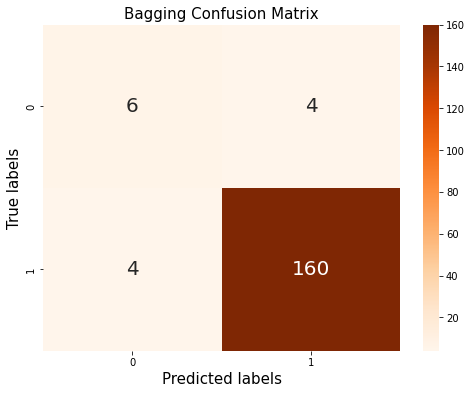

In [ ]:
# plot confusion matrix
classes = np.unique(bagging_true_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(bagging_cm, annot=True, cmap='Oranges', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Bagging Confusion Matrix', fontsize=15)
plt.show()

Bagging test accuracy = 0.9655172413793104, F1 score = 0.9818181818181818


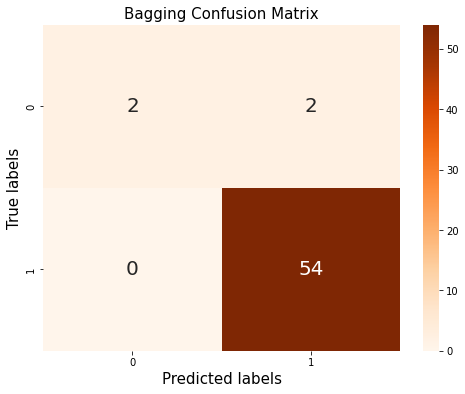

In [ ]:
# Bagging test
bagging_test_pred = bagging.predict(X_test)
bagging_test_prob = bagging.predict_proba(X_test)

bagging_test_acc = accuracy_score(y_test, bagging_test_pred)
bagging_test_f1 = f1_score(y_test, bagging_test_pred)
bagging_test_cm = confusion_matrix(y_test, bagging_test_pred)
print(f'Bagging test accuracy = {bagging_test_acc}, F1 score = {bagging_test_f1}')

classes = np.unique(y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(bagging_test_cm, annot=True, cmap='Oranges', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Bagging Confusion Matrix', fontsize=15)
plt.show()

### Model 4: Ensemble method

In [ ]:
from collections import Counter

ensemble_pred_cls = []

for knn_pred, bagging_pred, xgb_pred in zip(knn_pred_cls, bagging_pred_cls, xgb_pred_cls):
    preds = [knn_pred, bagging_pred, xgb_pred]

    counter = Counter(preds)
    # Find the most common element
    most_common_element = counter.most_common(1)[0][0]

    ensemble_pred_cls.append(most_common_element)


ensemble_acc = accuracy_score(knn_true_cls, ensemble_pred_cls)
ensemble_f1 = f1_score(knn_true_cls, ensemble_pred_cls)
ensemble_cm = confusion_matrix(knn_true_cls, ensemble_pred_cls)

print(f'Ensemble method accuracy = {ensemble_acc}, F1 score = {ensemble_f1}')

Ensemble method accuracy = 0.9655172413793104, F1 score = 0.9817073170731707


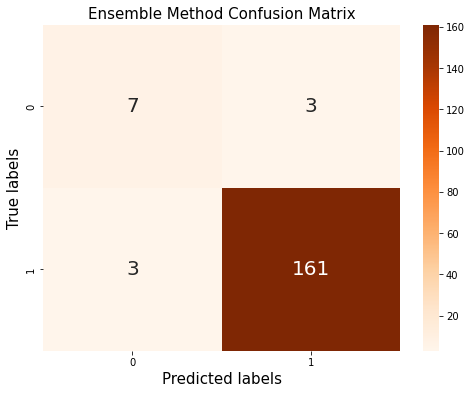

In [ ]:
classes = np.unique(knn_true_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, annot=True, cmap='Oranges', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Ensemble Method Confusion Matrix', fontsize=15)
plt.show()

In [ ]:
ensemble_pred_cls = []

for knn_pred, bagging_pred, xgb_pred in zip(knn_test_pred, bagging_test_pred, xgb_test_pred):
    preds = [knn_pred, bagging_pred, xgb_pred]

    counter = Counter(preds)
    # Find the most common element
    most_common_element = counter.most_common(1)[0][0]

    ensemble_pred_cls.append(most_common_element)


ensemble_acc = accuracy_score(y_test, ensemble_pred_cls)
ensemble_f1 = f1_score(y_test, ensemble_pred_cls)
ensemble_cm = confusion_matrix(y_test, ensemble_pred_cls)

print(f'Ensemble method accuracy = {ensemble_acc}, F1 score = {ensemble_f1}')

Ensemble method accuracy = 0.9655172413793104, F1 score = 0.9818181818181818


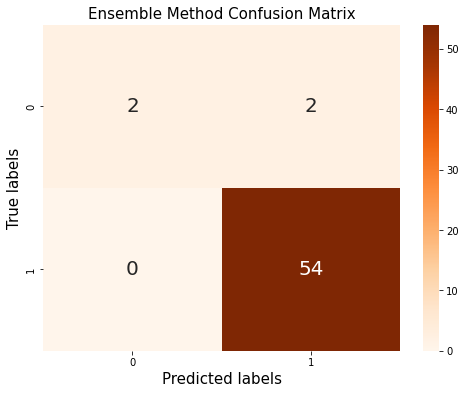

In [ ]:
classes = np.unique(xgb_true_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, annot=True, cmap='Oranges', fmt='g', xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Ensemble Method Confusion Matrix', fontsize=15)
plt.show()